In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from qolmat.imputations import preprocessing, imputers
from qolmat.imputations.imputers import ImputerRegressor
from qolmat.benchmark import missing_patterns
from qolmat.benchmark import comparator
from qolmat.utils import data

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.compose import make_column_selector as selector

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [3]:
df = data.get_data("Titanic")

In [4]:
cols_num = df.select_dtypes(include="number").columns
cols_cat = df.select_dtypes(exclude="number").columns

In [5]:
imputer_rpca = imputers.ImputerRpcaNoisy()
ohe = preprocessing.OneHotEncoderProjector(handle_unknown="ignore", handle_missing="return_nan", use_cat_names=True, cols=cols_cat)
bt = preprocessing.BinTransformer(cols=cols_num)
wrapper = Pipeline(steps=[("OneHotEncoder", ohe), ("BinTransformer", bt)])

imputer_wrap_rpca = preprocessing.WrapperTransformer(imputer_rpca, wrapper)

In [8]:
pipestimator = preprocessing.make_robust_MixteHGB(allow_new=False)
imputer_hgb = ImputerRegressor(estimator=pipestimator, handler_nan="none")
imputer_wrap_hgb = preprocessing.WrapperTransformer(imputer_hgb, bt)

In [9]:
imputer_simple = imputers.ImputerSimple()

In [21]:
dict_imputers = {"Simple": imputer_simple, "HGB": imputer_wrap_hgb, "RPCA": imputer_wrap_rpca}
cols_to_impute = df.columns
ratio_masked = .1
generator_holes = missing_patterns.UniformHoleGenerator(n_splits=2, subset=cols_to_impute, ratio_masked=ratio_masked, sample_proportional=False)
metrics = ["rmse", "accuracy"]

In [22]:
comparison = comparator.Comparator(
    dict_imputers,
    cols_to_impute,
    generator_holes = generator_holes,
    metrics=metrics,
    max_evals=2,
)
results = comparison.compare(df)

Testing model: Simple...done.
Testing model: HGB...done.
Testing model: RPCA...done.


In [23]:
display(results.loc["rmse"].style.highlight_min(color="lightgreen", axis=1))

,Simple,HGB,RPCA
age,13.722175,12.380136,14.044074
sibsp,1.207312,0.574931,0.895884
parch,0.933767,0.807345,0.839930
fare,434352.730672,504720.500563,507609.769959


In [24]:
display(results.loc["accuracy"].style.highlight_max(color="lightgreen", axis=1))

,Simple,HGB,RPCA
sex,0.667939,0.664122,0.664122
age,0.022901,0.038168,0.030534
sibsp,0.671756,0.763359,0.671756
parch,0.774809,0.751908,0.751908
fare,0.007634,0.007634,0.003817
embarked,0.698473,0.809160,0.687023


# Imputation analysis

In [14]:
mask = generator_holes.generate_mask(df)
df_corr = df.where(~mask, np.nan)
df_imp = imputer_wrap_hgb.fit_transform(df_corr)

In [15]:
ages = df[mask]["age"]
ages_imp = df_imp[mask]["age"]

In [16]:
mesh = np.arange(ages.max() + 1)
counts = ages.value_counts().reindex(mesh, fill_value=0)
counts_imp = ages_imp.value_counts().reindex(mesh, fill_value=0)

In [17]:
pd.concat([counts, counts_imp], axis=1)

,count,count
age,,
0.0,0,0
1.0,1,0
2.0,2,0
3.0,1,0
4.0,0,1
...,...,...
58.0,0,0
59.0,0,0
60.0,2,0


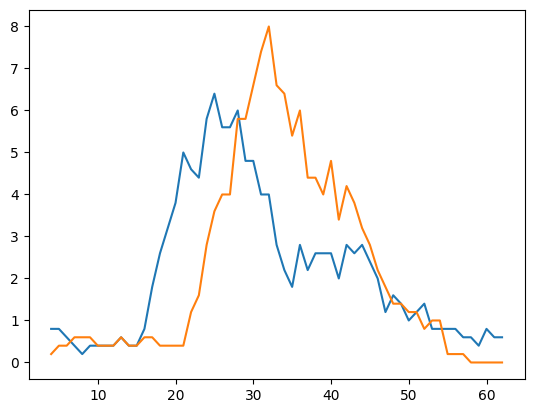

In [18]:
plt.plot(counts.rolling(5).mean())
plt.plot(counts_imp.rolling(5).mean())

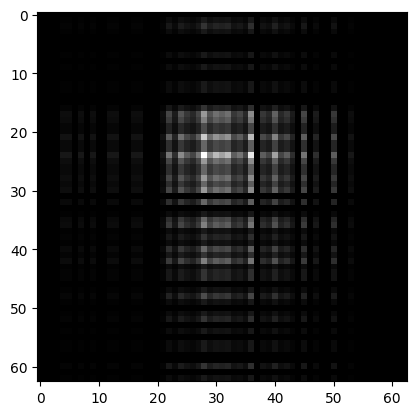

In [19]:
plt.imshow(counts.to_frame() @ counts_imp.to_frame().T, cmap="gray")

In [20]:
data.get_data("Beijing")

KeyError: 'date'